In [1]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import random


class CartPoleEnv3(gym.Env):
    

    #metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 50}

    def __init__(self):
        
        self.force_mag = 1.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                1,
                100,
                100,
                100,
        
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, b = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        d=1
         
        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        
        #t=[1,5,4] a and b number of devices
        reward=0
        a=0
        #b=20
        k=0
        
        #for i in range(20):
        
        
        if random.random()<.37:
            x = 1
            d+=1*force
            x_dot =x_dot+20+d
            theta = 3
            theta_dot = 4
            k+=1
            d+=1*force
            b+=1
            
            
            reward = 1+d
            
            
           
            
        else:
            
            x=0
            x_dot = x_dot+20+d
            theta = 3
            theta_dot = 4
            reward = -(1+d)
            
            
            b-=1
            a+=1
        #if self.kinematics_integrator == "euler":
        #x = t[0][0]
        
          
        self.state = (x, x_dot, theta, b)

        done = bool(x_dot>4000)
        
        a=a
        b=b
       
        

        return np.array(self.state, dtype=np.float32),b, done, {}


    def reset(self):
        
        #self.state = self.np_random.randint(low=0, high=1, size=(4,))
       self.state = (1),(1),(1),(1)
      
       #self.state = self.np_random.uniform(low=0, high=0, size=(4,))
       #self.state=self.np.random.uniform(size = (4,), low = 0, high = 1)
       self.steps_beyond_done = None
       return np.array(self.state, dtype=np.float32)

    

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.mem_size, *input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import gym

def plotLearning(x, scores, epsilons,lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Number of devices', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

   

<ipython-input-2-d8bb0beb7a3a>:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  state = T.tensor([observation]).to(self.Q_eval.device)


episode  0 score -5397.00 average score -5397.00 epsilon 0.94
episode  1 score -6895.00 average score -6146.00 epsilon 0.84
episode  2 score -3382.00 average score -5224.67 epsilon 0.75
episode  3 score -5614.00 average score -5322.00 epsilon 0.65
episode  4 score -5752.00 average score -5408.00 epsilon 0.55
episode  5 score -5544.00 average score -5430.67 epsilon 0.46
episode  6 score -6332.00 average score -5559.43 epsilon 0.36
episode  7 score -3958.00 average score -5359.25 epsilon 0.26
episode  8 score -6078.00 average score -5439.11 epsilon 0.17
episode  9 score -3216.00 average score -5216.80 epsilon 0.07
episode  10 score -4079.00 average score -5113.36 epsilon 0.01
episode  11 score -2833.00 average score -4923.33 epsilon 0.01
episode  12 score -5195.00 average score -4944.23 epsilon 0.01
episode  13 score -4291.00 average score -4897.57 epsilon 0.01
episode  14 score -2189.00 average score -4717.00 epsilon 0.01
episode  15 score -5473.00 average score -4764.25 epsilon 0.01
ep

episode  130 score -3746.00 average score -4490.61 epsilon 0.01
episode  131 score -3981.00 average score -4487.97 epsilon 0.01
episode  132 score -7402.00 average score -4484.64 epsilon 0.01
episode  133 score -4052.00 average score -4471.77 epsilon 0.01
episode  134 score -3818.00 average score -4458.94 epsilon 0.01
episode  135 score -5872.00 average score -4473.59 epsilon 0.01
episode  136 score -4374.00 average score -4447.54 epsilon 0.01
episode  137 score -3354.00 average score -4442.49 epsilon 0.01
episode  138 score -3497.00 average score -4438.41 epsilon 0.01
episode  139 score -4796.00 average score -4448.22 epsilon 0.01
episode  140 score -4215.00 average score -4436.34 epsilon 0.01
episode  141 score -4276.00 average score -4429.29 epsilon 0.01
episode  142 score -5618.00 average score -4435.24 epsilon 0.01
episode  143 score -7738.00 average score -4441.77 epsilon 0.01
episode  144 score -7644.00 average score -4483.32 epsilon 0.01
episode  145 score -2857.00 average scor

episode  259 score -3858.00 average score -4355.30 epsilon 0.01
episode  260 score -7420.00 average score -4378.84 epsilon 0.01
episode  261 score -2137.00 average score -4354.10 epsilon 0.01
episode  262 score -5138.00 average score -4368.65 epsilon 0.01
episode  263 score -6280.00 average score -4377.45 epsilon 0.01
episode  264 score -3155.00 average score -4355.72 epsilon 0.01
episode  265 score -4106.00 average score -4348.80 epsilon 0.01
episode  266 score -6352.00 average score -4390.52 epsilon 0.01
episode  267 score -3310.00 average score -4387.66 epsilon 0.01
episode  268 score -5402.00 average score -4405.23 epsilon 0.01
episode  269 score -5992.00 average score -4411.01 epsilon 0.01
episode  270 score -6418.00 average score -4447.86 epsilon 0.01
episode  271 score -3680.00 average score -4445.29 epsilon 0.01
episode  272 score -2155.00 average score -4406.14 epsilon 0.01
episode  273 score -2755.00 average score -4400.43 epsilon 0.01
episode  274 score -597.00 average score

episode  388 score -5502.00 average score -4315.97 epsilon 0.01
episode  389 score -4894.00 average score -4322.86 epsilon 0.01
episode  390 score -5004.00 average score -4323.24 epsilon 0.01
episode  391 score -5504.00 average score -4344.82 epsilon 0.01
episode  392 score -4494.00 average score -4341.60 epsilon 0.01
episode  393 score -5676.00 average score -4361.79 epsilon 0.01
episode  394 score -5780.00 average score -4378.01 epsilon 0.01
episode  395 score -5808.00 average score -4392.13 epsilon 0.01
episode  396 score -3876.00 average score -4412.24 epsilon 0.01
episode  397 score -3896.00 average score -4402.27 epsilon 0.01
episode  398 score -5062.00 average score -4396.63 epsilon 0.01
episode  399 score -6410.00 average score -4429.54 epsilon 0.01
episode  400 score -3917.00 average score -4428.45 epsilon 0.01
episode  401 score -3556.00 average score -4430.67 epsilon 0.01
episode  402 score -4960.00 average score -4424.89 epsilon 0.01
episode  403 score -5022.00 average scor

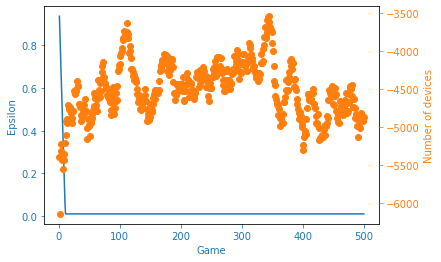

In [4]:
import gym
#from simple_dqn_torch_2020 import Agent
#from utils import plotLearning
import numpy as np

#t=[[0,5,4],[0,4,4],[0,3,4],[0,3,4],[0,3,4],[1,7,4],[1,8,4],[0,3,4],[0,8,4]]
if __name__ == '__main__':
    #env = gym.make('CartPole-v1')
    env=CartPoleEnv3()
    agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=2, eps_end=0.01,
                  input_dims=[4], lr=0.1)
    scores, eps_history = [], []
    n_games =500
    x_dot=20
    #dot=[[1,20],[1,21],[1,22],[1,24],[1,25],[1,20],[1,21],[1,22],[1,24],[1,25],[1,20],[1,21],[1,22],[1,24],[1,25],[1,20],[1,21],[1,22],[1,24],[1,25]]
    
    for i in range(n_games):
        score = 0
        score1=0
        #b=20
        done = False
        observation = env.reset()
        #observation=env.step(action)
        
        while not done:
            
            action = agent.choose_action(observation)
            observation_, b, done, info = env.step(action)
            score += b
         
            agent.store_transition(observation, action, b, 
                                    observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)
        
        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)
    x = [i+1 for i in range(n_games)]
    #filename = 'lunar_lander.png'
    plotLearning(x, scores, eps_history)

In [5]:
import random
t=[[1,5,4],[1,4,4],[1,3,4],[1,3,4],[1,3,4],[1,7,4],[1,8,4],[1,3,4],[1,8,4]]
for i in range(len(t)):
  r=random.choices(t)
  if random.random()<.5:
        if r[0][0]==1 and random.random()<math.exp(-1):
          print(r[0][1])
  else:
    print('wrong')


8
8
3


In [6]:
r=math.exp(-1)
print(r)

0.36787944117144233


In [7]:
t=[[1,5,4],[1,4,4],[1,3,4],[1,3,4],[1,3,4],[1,7,4],[1,8,4],[1,3,4],[1,8,4]]
for i in range(len(t)):
    x=t[i][0]+5
    t[i][0]=x
    print(t[i][0])
    

6
6
6
6
6
6
6
6
6


In [8]:
t=[[1,5,4],[1,4,4],[1,3,4],[1,3,4],[1,3,4],[0,7,4],[1,8,4],[1,3,4],[1,8,4]]

a=0
for i in range(len(t)):
  if t[i][0]==1:
     a-=1
    
    
print(a)
    

-8


In [9]:
 a=0
         for i in range(len(t)):
           if t[i][0]==1:
              a+=1
         b=9-a
        

IndentationError: unexpected indent (<ipython-input-9-dc416451fd1b>, line 2)

In [ ]:
np.zeros((5,3), dtype=int)

In [ ]:
[3]*[3]

In [ ]:
%history -g -f MDP_IOT


In [ ]:
%history -g

In [ ]:
state = np_random.uniform(low=0, high=1, size=(4,))


In [ ]:
for i in range(100):
 print(random.random())

In [ ]:
s = (2,3)
np.zeros(s)

In [ ]:
max([4,2],[4,7])